### ENSIMAG – Grenoble INP – UGA - Academic year 2025-2026
# Introduction to Statistical Learning and Applications ([website](https://github.com/ISLA-Grenoble/2026-main))

- Pedro L. C. Rodrigues -- `pedro.rodrigues@inria.fr`

- Isabella Costa Maia -- `isabella.costa-maia@grenoble-inp.fr`

***

### ⚠️ General guidelines for TPs

Each team shall upload its report on [Teide](https://teide.ensimag.fr/) before the deadline indicated at the course website. Please
**include the name of all members** of the team on top of your report.
The report should contain graphical representations and explanatory text. For each graph, axis names should be provided as well
as a legend when it is appropriate. Figures should be explained by a few sentences in the text. Answer to
the questions in order and refer to the question number in your report. Computations and
graphics have to be performed in `python`. The report should be written as a jupyter notebook. This is a file format that allows users to format documents containing text written in markdown and `python` instructions. You should include all of the `python` instructions that you have used in the document so that it may be possible to replicate your results.

***

# 🖥️ TP1: Analysis of prostate cancer data

A medical study done on patients with prostate cancer aims to analyze the correlation between the prostate tumor volume and a set of clinical and morphometric variables. These variables include prostate specific antigens, a biomarker for prostate cancer, and a number of clinical measures (age, prostate weight, etc). The goal of this lab is to build a regression model to predict the severity of cancer, expressed by logarithm of the tumor volume -- `lcavol` variable -- from the following predictors:
- `lpsa`: log of a prostate specific antigen
- `lweight`: log of prostate weight
- `age`: age of the patient
- `lbph`: log of benign prostatic hyperplasia amount
- `svi`: seminal vesicle invasion
- `lcp`: log of capsular penetration
- `gleason`: Gleason score (score on a cancer prognosis test)
- `pgg45`: percent of Gleason scores 4 or 5

The file `prostate.data`, available [here](https://github.com/ISLA-Grenoble/2025-main/blob/main/TP/TP1/prostate.data), contains measures of the logarithm of the tumor
volume and of the 8 predictors for 97 patients. This file also contains an additional variable, called `train`, which will
not be used and has to be removed.

## ▶️ Exercise 1: Preliminary analysis of the data (1 points)

**(a)** Download the file `prostate.data` and store it in your current folder. Read the dataset in using `pandas` as per
```
import pandas as pd
df = pd.read_csv("prostate.data", sep="\t")
```
check how to use function `df.drop` to remove the first and last columns of `df` containing useless tags.

In [6]:
import pandas as pd
df = pd.read_csv("prostate.data", sep="\t")
# Drop useless columns: index + train
df = df.drop(columns=['Unnamed: 0', 'train'])

**(b)** The function defined below generates scatterplots (clouds of points) between all pairs of variables, allowing us to visually analyse the correlations between all variables in the dataframe. Explain what each line of function `pairplot` does and how it affects the final plot. You can use command `help` in the `python` shell to get the documentation of each function.

``` 
# import the main plotting library for python
import matplotlib.pyplot as plt

# make a pairplot from scratch
def pairplot(df, figsize=None):
    if figsize is None:
        figsize = (7.10, 6.70)
    n_vars = df.shape[1]
    fig, ax = plt.subplots(figsize=figsize, ncols=n_vars, nrows=n_vars)
    plt.subplots_adjust(
        wspace=0.10, hspace=0.10, left=0.05, right=0.95, bottom=0.05, top=0.95)
    for i in range(n_vars):
        for j in range(n_vars):
            axij = ax[i][j]
            i_name = df.columns[i]
            j_name = df.columns[j]
            axij.set_xticks([])
            axij.set_yticks([])
            axij.margins(0.1)
            if i != j:
                axij.scatter(df[i_name], df[j_name], s=10)
            else:
                axij.text(0.5, 0.5, i_name, fontsize=10,
                              horizontalalignment='center',
                              verticalalignment='center',
                              transform = axij.transAxes)        
    return fig, ax

fig, ax = pairplot(df)
plt.show()
```

**(c)** Based on the generated figure, identify which variables seem the most correlated to `lcavol`. Also, infer the datatype for each of the predictors.

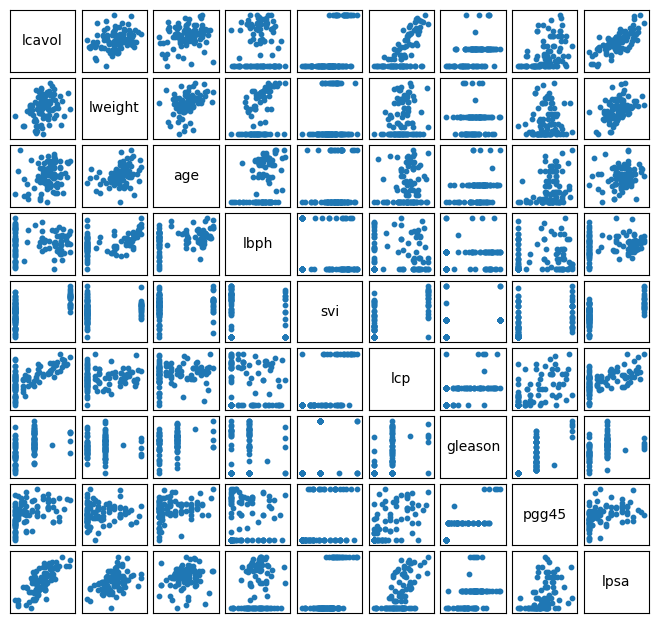

In [7]:
# import the main plotting library for python
import matplotlib.pyplot as plt

# make a pairplot from scratch
def pairplot(df, figsize=None):
    if figsize is None:
        figsize = (7.10, 6.70)
    n_vars = df.shape[1]
    fig, ax = plt.subplots(figsize=figsize, ncols=n_vars, nrows=n_vars)
    plt.subplots_adjust(
        wspace=0.10, hspace=0.10, left=0.05, right=0.95, bottom=0.05, top=0.95)
    for i in range(n_vars):
        for j in range(n_vars):
            axij = ax[i][j]
            i_name = df.columns[i]
            j_name = df.columns[j]
            axij.set_xticks([])
            axij.set_yticks([])
            axij.margins(0.1)
            if i != j:
                axij.scatter(df[i_name], df[j_name], s=10)
            else:
                axij.text(0.5, 0.5, i_name, fontsize=10,
                              horizontalalignment='center',
                              verticalalignment='center',
                              transform = axij.transAxes)        
    return fig, ax

fig, ax = pairplot(df)
plt.show()

**Comment:**  

Based on the figure, the variables that appear most strongly correlated with \texttt{lcavol} are (in order of importance):  

- lpsa}  
- lcp  
- age  

The categorical variables, on the other hand, are more difficult to interpret directly from simple correlation plots.  
- svi has 2 categories (0 or 1), so its effect is captured by a single indicator variable, and the coefficient represents the average difference in lcavol between patients with svi=1 versus svi=0.  
- gleason has 4 categories (6, 7, 8, 9), which are encoded using three dummy variables (taking Gleason = 6 as the reference). Each coefficient indicates the average effect of being in that Gleason category compared to the reference.  

**(d)** Recall the formula of correlation between two vectors and implement it with `numpy`. Explain the difference of your result when compared to `df.corr()`. Change the function `pairplot`to show the correlation coefficient on the upper triangle of the subplots. (Bonus) Use locally weighted scatterplot smoothing (LOWESS) to see the trends between pairs of features with `statsmodels.nonparametric.smoothers_lowess`.

In [37]:
import numpy as np

def corr_numpy(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    x_centered = x - x.mean()
    y_centered = y - y.mean()
    return (x_centered @ y_centered) / (
        np.sqrt((x_centered @ x_centered) * (y_centered @ y_centered))
    )

r_lcavol_svi = corr_numpy(df["lcavol"], df["svi"])
r_lcavol_lcp = corr_numpy(df["lcavol"], df["lcp"])

print("corr(lcavol, svi) =", r_lcavol_svi)
print("corr(lcavol, lcp) =", r_lcavol_lcp)


corr(lcavol, svi) = 0.5388450022638601
corr(lcavol, lcp) = 0.6753104840558687


## ▶️ Exercise 2: Linear regression (7 points)

In this exercise, we will perform a multiple linear regression to build a predictive model for the `lcavol` variable. The variables `gleason` and `svi` should be considered as qualitative variables. You can declare them as such with

```
df['svi'] = df['svi'].astype("category")
df['gleason'] = df['gleason'].astype("category")
```

**(a)** Provide the mathematical equation of the regression model (note that you can use LaTeX to write equations) and define the diﬀerent parameters. 

Let $Y_i = \text{lcavol}_i$ be the response variable for observation $i$, and let $X_i = (X_{i1}, X_{i2}, \dots, X_{ip})$ be the vector of predictors, including numerical variables and the one-hot encoded categorical variables for svi and gleason. The regression model is:

$$
Y_i = \beta_0 + \beta_1 \cdot \text{lweight}_i + \beta_2 \cdot \text{age}_i + \beta_3 \cdot \text{lbph}_i + \beta_4 \cdot \text{lcp}_i + \beta_5 \cdot \text{pgg45}_i + \beta_6 \cdot \text{lpsa}_i + \beta_7 \cdot \text{svi}_1^{(i)} + \beta_8 \cdot \text{gleason}_7^{(i)} + \beta_9 \cdot \text{gleason}_8^{(i)} + \beta_{10} \cdot \text{gleason}_9^{(i)} + \varepsilon_i,
$$

where:

- $\beta_0$ is the intercept term.  
- $\beta_1, \dots, \beta_6$ are the coefficients for the continuous predictors: lweight, age, lbph, lcp, pgg45, lpsa.  
- $\beta_7$ represents the effect of having $\text{svi} = 1$ relative to the reference category $\text{svi} = 0$.  
- $\beta_8, \beta_9, \beta_{10}$ represent the effects of Gleason scores 7, 8, and 9 respectively, relative to the reference category Gleason = 6.  
- $\varepsilon_i$ is the error term $i$, assumed to follow the Gaussian distribution with the following parameters $\mathbb{E}[\varepsilon_i] = 0$ and $\text{Var}(\varepsilon_i) = \sigma^2$.

The model can be written more compactly in matrix form as:

$$
\mathbf{Y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\varepsilon},
$$

where $\mathbf{Y} \in \mathbb{R}^{n}$ is the vector of responses, $\mathbf{X} \in \mathbb{R}^{n \times (p+1)}$ is the predictors matrix including a column of ones for the intercept, $\boldsymbol{\beta} \in \mathbb{R}^{p}$ is the vector of coefficients, and $\boldsymbol{\varepsilon} \in \mathbb{R}^{n}$ is the vector of the gaussian errors.


**(b)** Before doing the linear regression of this TP, you will first have to handle the one-hot encoding of the categorical features of the dataframe. One way of doing this is as follows:

```
# encode the categorical features with dummy variables
df_enc = pd.get_dummies(df, dtype=np.float64)
# to drop one dummy column for each predictor
df_enc = df_enc.drop(columns=['svi_0', 'gleason_6'])
# add a column of ones to the dataframe
df_enc['intercept'] = 1
# extract the dataframe for predictors
X = df_enc.drop(columns=['lcavol'])
# get the observed values to predict
y = df['lcavol']
```

- Why did we fix a `dtype` in `pd.get_dummies`?
- Why did we drop two columns after the encoding?
- Why did we add a column of ones to the dataframe?

In [38]:
# First we tell panda that svi and gleason are categorical variables
df['svi'] = df['svi'].astype('category')
df['gleason'] = df['gleason'].astype('category')
# encode the categorical features with dummy variables
# they have to ble float as statsmodels expects floats
df_enc = pd.get_dummies(df, dtype=np.float64)
df_enc.columns
# to drop one dummy column for each predictor (to avoid multicollinearity, otherwise our matrix won't be reversible)
df_enc = df_enc.drop(columns=['svi_0', 'gleason_6'])
# add a column of ones to the dataframe (for the intercept)
df_enc['intercept'] = 1
# extract the dataframe for predictors
X = df_enc.drop(columns=['lcavol']) # it's enough to take out our response variable
# get the observed values to predict
y = df['lcavol']

**(c)** We will use the [`statsmodels`](https://www.statsmodels.org/) package to estimate the coefficients of the multiple linear regression as per:

```
# import required package
import statsmodels.api as sm
# this line does not fit the regression model per se but only builds it
model = sm.OLS(y, X)
# now we actually fit the model, e.g. calculate all of regression parameters
results = model.fit()
```

Use command `results.sumary()` to get the statistical summary of the estimated coefficients. 

- Explain to what correspond the regression coeﬃcients for the lines related to `svi` and `gleason`. 

- What would have happened in the regression if we did not do the one-hot encoding from above?

- Comment the overall results of the regression as well.

In [39]:
# import required package
import statsmodels.api as sm
# this line does not fit the regression model per se but only builds it
model = sm.OLS(y, X)
# now we actually fit the model, e.g. calculate all of regression parameters
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lcavol   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     18.83
Date:                Sun, 15 Feb 2026   Prob (F-statistic):           9.05e-18
Time:                        20:34:02   Log-Likelihood:                -96.825
No. Observations:                  97   AIC:                             215.7
Df Residuals:                      86   BIC:                             244.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lweight       -0.0112      0.211     -0.053      0.958      -0.432       0.409
age            0.0248      0.011      2.205      0.030       0.002       0.047
lbph          -0.1042      0.058     -1.790      0.077      -0.220       0.012
lcp            0.4028      0.085      4.734      0.000       0.234       0.572
pgg45         -0.0094      0.005     -2.080      0.040      -0.018      -0.000
lpsa           0.5496      0.090      6.100      0.000       0.370       0.729
svi_1         -0.2204      0.256     -0.860      0.392      -0.730       0.289
gleason_7      0.3117      0.215      1.448      0.151      -0.116       0.740
gleason_8     -0.7106      0.759     -0.936      0.352      -2.219       0.798
gleason_9      0.7901      0.488      1.621      0.109      -0.179       1.759
intercept     -1.4067      0.874     -1.609      0.111      -3.145       0.332
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.127
Skew:                          -0.073   Prob(JB):                        0.939
Kurtosis:                       2.900   Cond. No.                         884.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**1)**

The coefficient associated with $\text{SVI}_1$ represents the **average difference** in the response variable $Y$
between patients with $\text{SVI}=1$ and patients with $\text{SVI}=0$.
It is a mean difference because the noise term is assumed to have zero mean, but is not identically zero.

Consider the linear regression model:

$$
Y = \beta_0 + ... + \beta_\text{svi} \cdot \text{SVI}_1 + \varepsilon,
$$

where $\text{SVI}_1 \in \{0,1\}$, $\varepsilon$ is a random noise term such that
$\mathbb{E}[\varepsilon] = 0$, and $...$ denotes the contributions of the other predictors.

When $\text{SVI}_1 = 0$:

$$
Y = \beta_0 + ... + \varepsilon
$$

When $\text{SVI}_1 = 1$:

$$
Y = \beta_0 + ... + \beta_\text{svi} + \varepsilon
$$

The only systematic difference between these two situations is $\beta_\text{svi}$.
Taking expectations, we have:

$$
\mathbb{E}[Y \mid \text{SVI}_1 = 1] - \mathbb{E}[Y \mid \text{SVI}_1 = 0] = \beta_\text{svi}.
$$

Therefore, $\beta_\text{svi}$ measures the **average effect** of having SVI, **controlling for all other predictors**.



Similarly, the coefficients associated with the Gleason indicators represent the **average difference** in $Y$
between each Gleason category and the reference category, while accounting for the other variables.

Suppose the Gleason score takes values in $\{6,7,8,9\}$, with Gleason $=6$ as the reference.
We introduce dummy variables (dropping Gleason $=6$):

$$
\text{Gleason}_\text{g7}, \ \text{Gleason}_\text{g8}, \ \text{Gleason}_\text{g9} \in \{0,1\},
$$

and consider the linear regression model:

$$
Y = \beta_0 + ... + \beta_\text{g7} \cdot \text{Gleason}_7 + \beta_\text{g8} \cdot \text{Gleason}_8 + \beta_\text{g9} \cdot \text{Gleason}_9 + \varepsilon,
$$

where $...$ again represents all other predictors included in the model.

- When Gleason $=6$ (reference):

$$
Y = \beta_0 + ... + \varepsilon
$$

- When Gleason $=7$:

$$
Y = \beta_0 + ... + \beta_\text{g7} + \varepsilon
$$

- When Gleason $=8$:

$$
Y = \beta_0 + ... + \beta_\text{g8} + \varepsilon
$$

- When Gleason $=9$:

$$
Y = \beta_0 + ... + \beta_\text{g9} + \varepsilon
$$

Thus, for $k \in \{7,8,9\}$:

$$
\mathbb{E}[Y \mid \text{Gleason} = k] - \mathbb{E}[Y \mid \text{Gleason} = 6] = \beta_\text{g8}.
$$


In other words, each $\beta_k$ represents the **average effect** of being in Gleason category $k$ compared to the reference.
This is the same concept as $\beta_\text{svi}$, generalized to a categorical variable with multiple levels.


**2)**
If we did not do the One-hot encoding from above Categorical variables will be interpreted as continuous, and the model would assume a linear behavior for Gleason and Svi. For example: $\text{Gleason}=9$ is “three times worse” (because the slope is positive) than $\text{Gleason}=3$, which is **not meaningful** as it doesn't mean the intensity but rather the classification.  
So the One-hot encoding avoids this, enabling coefficients to be **interpreted relative to a reference category**.



**3)**
**Overall interpretation of the regression results**

The regression model explains a substantial proportion of the variability in the response variable.
We have:

$$
R^2 = 0.686,
$$

which indicates that approximately 68.6\% of the total variance in $Y$ is explained by the predictors included in the model.

Formally, $R^2$ can be written as

$$
R^2 = 0.686,
$$

which indicates that approximately 68.6\% of the total variance in $Y$ is explained by the predictors included in the model.

Formally, $R^2$ can be written as

$$
R^2 = \frac{\text{ESS}}{\text{TSS}},
$$

where:  

- $\text{ESS} = \sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2$ is the **Explained Sum of Squares**, representing the variability captured by the model.  
- $\text{TSS} = \sum_{i=1}^{n} (y_i - \bar{y})^2$ is the **Total Sum of Squares**, representing the total variability of the data.  
- $\text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ is the **Residual Sum of Squares**, measuring the discrepancy between observed and predicted values.  

It follows that
$$
\text{TSS} = \text{ESS} + \text{RSS},
$$


So $\text{ESS} = \text{TSS} - \text{RSS} \rightarrow R^2 = 1 - \frac{RSS}{TSS}$ is nothing but the portian of data for which the variability is actually well explained by the model.

It is worthy of mentioning that in the case of a simple regression:
$$R^2 = r_{XY}^2$$, in other words **The correlation coefficient squared**

In fact:
If we consider the model
$$
y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, \quad i = 1,\dots,n
$$

with predicted values
$$
\hat{y}_i = \beta_0 + \beta_1 x_i.
$$

The slope estimate is
$$
\hat{\beta}_1 = \frac{c_{XY}}{s_{X}²} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}.
$$

---

The explained sum of squares is
$$
\text{ESS} = \sum_{i=1}^n (\hat{y}_i - \bar{y})^2.
$$

Since
$$
\hat{y}_i - \bar{y} = \hat{\beta}_1 (x_i - \bar{x}),
$$
we have
$$
\text{ESS} = \sum_{i=1}^n (\hat{\beta}_1 (x_i - \bar{x}))^2 = \hat{\beta}_1^2 \sum_{i=1}^n (x_i - \bar{x})^2 = (\frac{c_{XY}}{s_{X}²})² \sum_{i=1}^n (x_i - \bar{x})^2 = (\frac{c_{XY}}{s_{X}²})² s_{X}² N².
$$


So
$$
\text{ESS} = (\frac{c_{XY}}{s_{X}})²N²
$$

---

The total sum of squares is
$$
\text{TSS} = \sum_{i=1}^n (y_i - \bar{y})^2 = N²s_{Y}².
$$

Therefore,
$$
R^2 = \frac{c_{XY}²}{s_{X}² s_{Y}²} = r_{XY}²
$$

After adjusting for the number of predictors, the adjusted coefficient of determination is

$$
R^2_{\text{adj}} = 0.650.
$$

The small decrease between $R^2$ and $R^2_{\text{adj}}$ suggests that the model does not suffer from severe overfitting and that most included predictors contribute meaningfully to the explanation of $Y$.

In fact **The adjusted R-squared** is defined as (and again i had to look it up):

$$
R_\text{adj}^2 = 1 - \frac{n-1}{n-p-1} (1 - R^2)
$$
and since adding new predictors can increase R² (with more freedom degrees we can shrink the difference $(y_i - \hat{y_i}$ even more), $R_\text{adj}$ 

where:
$n$ is the number of observations,
$p$ is the number of predictors (excluding the intercept),
$R^2$ is the usual coefficient of determination.

In multiple regression, adding more predictors always increases $R^2$, even if the new predictors do not explain any additional variance.
The factor $\frac{n-1}{n-p-1}$ penalizes the addition of unnecessary variables.

However since $R_\text{adj}^2$ is not that far from $R^2$ most of the predictors are significant.

The global significance of the model is assessed using the F-test:

$$
H_0 : \beta_1 = \beta_2 = \dots = \beta_p = 0.
$$

The associated p-value is extremely small (e.g., $p < 0.001$), leading to the rejection of $H_0$ at the 5\% significance level.
Therefore, the model is globally significant, meaning that at least one predictor has a non-zero effect on the response variable.

To be more precise, we will showcase which predictors actually contribute to our model in a way that explains the evolution of **lcavol**:

- **Significant predictors** (p-value $< 0.05$):  
  - $\text{age}$, $\text{lcp}$, $\text{pgg45}$, $\text{lpsa}$.

- **Non-significant predictors** (p-value $\geq 0.05$):  
  - $\text{lweight}$, $\text{lbph}$ (borderline), $\text{svi}_1$, $\text{gleason}_7$, $\text{gleason}_8$, $\text{gleason}_9$, intercept.  

Overall, the model suggests that $\text{lcavol}$ is mainly influenced by the significant predictors listed above.

In conclusion, the regression model provides a statistically significant and reasonably strong explanation of the variability in $Y$.
However, while the model explains a large proportion of the variance, a non-negligible part of variability remains unexplained, indicating the presence of other influencing factors or random noise.


**(d)** Use `results.conf_int` to get confidence intervals of level 95% for all the coeﬃcients of the predictors. Comment the results.

In [40]:
results.conf_int(alpha=0.05)

,0,1
lweight,-0.431600,0.409107
age,0.002436,0.047129
lbph,-0.219914,0.011515
lcp,0.233639,0.571880
pgg45,-0.018469,-0.000419
lpsa,0.370474,0.728673
svi_1,-0.730029,0.289190
gleason_7,-0.116263,0.739616
gleason_8,-2.219087,0.797911
gleason_9,-0.179004,1.759273


**Confidence intervals for the regression coefficients**

The way this output could be analysed is as follows
- If a confidence interval **does not include 0**, the corresponding predictor is considered statistically significant at the 5\% level, as it simply means that it is statisticaly unlikely for the corresponding **slop** to be zero.
- For instance:  
  - $\text{age}$: $[0.0024, 0.0471]$ does not include 0 $\Rightarrow$ significant.  
  - $\text{lcp}$: $[0.234, 0.572]$ does not include 0 $\Rightarrow$ significant.  
  - $\text{lpsa}$: $[0.370, 0.729]$ does not include 0 $\Rightarrow$ significant.
  - $\text{pgg45}$: $[-0.0184, -0.0004]$ does not include 0 $\Rightarrow$ significant.    

- On the other hand, predictors like $\text{lweight}$ ($[-0.432, 0.409]$), $\text{svi}_1$ ($[-0.730, 0.289]$), and the Gleason dummies include 0, suggesting they are **not statistically significant** at this confidence level.


**(e)** What can you say about the eﬀects of the `lpsa` variable? Relate your answer to the $p$-value of a hypothesis test and a confidence interval. You can use `results.pvalues`.

In [41]:
results.pvalues

lweight      9.577075e-01
age          3.014993e-02
lbph         7.695609e-02
lcp          8.577858e-06
pgg45        4.047741e-02
lpsa         2.939241e-08
svi_1        3.922717e-01
gleason_7    1.512950e-01
gleason_8    3.516744e-01
gleason_9    1.087313e-01
intercept    1.113676e-01
dtype: float64

**Effect of the $\text{lpsa}$ variable**

The coefficient of $\text{lpsa}$ is $\hat{\beta}_{\text{lpsa}} = 0.5496$, with a 95\% confidence interval $[0.370, 0.729]$ and a p-value $< 0.001$ (from results.pvalues).  

- The confidence interval does not include 0, confirming that $\text{lpsa}$ has a **significant positive effect** on $\text{lcavol}$ just as we discussed in **c)**.  
- The p-value at 2.939241e-08 being very small (it is in fact the smallest of all p-values) we **reject the null hypothesis** $H_0: \beta_{\text{lpsa}} = 0$, so this predictor contributes meaningfully to the model.

**(f)** Implement yourself a function that calculates the values of the parameters and their corresponding $p$-values. Bonus: explain why `numpy.linalg.inv` is not necessarily the best choice for estimating the parameters as compared to `numpy.linalg.solve`.

In [42]:
from scipy import stats
def compute_ols(X, y, biased):
    beta_hat = np.linalg.solve(X.T @ X, X.T @ y)
    N,p = X.shape
    print((N,p))
    # to compute the p-value we need to calculate the test statistic first
    # I would've used a non biased estimator (simply by multiplying sigma2 by 1/N-(P+1), but i'll just follow the slides as they are
    if biased :
        sigma2 = ((y - X @ beta_hat).T @ (y - X @ beta_hat))/N # sigma2 = ||y - XBeta_hat||²/N
    else:
        sigma2 = ((y - X @ beta_hat).T @ (y - X @ beta_hat))/(N - p) # sigma2 = ||y - XBeta_hat||²/N
    I = np.eye(X.shape[1])
    covar_beta = sigma2 * np.linalg.solve(X.T @ X, I)
    var_beta = np.diag(covar_beta)
    se_beta = np.sqrt(var_beta)

    #t-statistics and p-values
    t_stats = beta_hat / se_beta
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=N-p-1)) #student test with a degree of N - p -1

    return beta_hat, se_beta, t_stats, p_values

# Verification
beta, se, t, p = compute_ols(X.values, y.values, True)
betau, seu, tu, pu = compute_ols(X.values, y.values, False)

model = sm.OLS(y, X)
# now we actually fit the model, e.g. calculate all of regression parameters
results = model.fit()
# Display comparison
comparison_biased = pd.DataFrame({
    'beta_manual': beta,
    'beta_sm': results.params,
    'se_manual': se,
    'se_sm': results.bse,
    't_manual': t,
    't_sm': results.tvalues,
    'p_manual': p,
    'p_sm': results.pvalues
}, index=X.columns)

comparison_unbiased = pd.DataFrame({
    'beta_manual': betau,
    'beta_sm': results.params,
    'se_manual': seu,
    'se_sm': results.bse,
    't_manual': tu,
    't_sm': results.tvalues,
    'p_manual': pu,
    'p_sm': results.pvalues
}, index=X.columns)

print("comparing our function with that of sm :")
print("")
print("case 1 - Biased estimisator of sigma2 :")
print("")
print(comparison_biased)

print("")
print("")
print("case 1 - Unbiased estimisator of sigma2 :")
print("")
print(comparison_unbiased)



(97, 11)
(97, 11)
comparing our function with that of sm :

case 1 - Biased estimisator of sigma2 :

           beta_manual   beta_sm  se_manual     se_sm  t_manual      t_sm  \
lweight      -0.011246 -0.011246   0.199102  0.211453 -0.056485 -0.053185   
age           0.024782  0.024782   0.010585  0.011241  2.341380  2.204628   
lbph         -0.104200 -0.104200   0.054809  0.058209 -1.901147 -1.790107   
lcp           0.402760  0.402760   0.080105  0.085074  5.027916  4.734252   
pgg45        -0.009444 -0.009444   0.004275  0.004540 -2.209301 -2.080263   
lpsa          0.549573  0.549573   0.084831  0.090093  6.478431  6.100047   
svi_1        -0.220419 -0.220419   0.241379  0.256351 -0.913168 -0.859833   
gleason_7     0.311676  0.311676   0.202695  0.215268  1.537659  1.447850   
gleason_8    -0.710588 -0.710588   0.714507  0.758827 -0.994516 -0.936429   
gleason_9     0.790135  0.790135   0.459036  0.487510  1.721290  1.620755   
intercept    -1.406654 -1.406654   0.823381  0.87445

We computed the standard errors, t-statistics, and p-values for the regression coefficients using both the biased 
$\hat{\sigma}^2_\text{biased} = \frac{||y - X\hat{\beta}||^2}{N}$ and the unbiased 
$\hat{\sigma}^2_\text{unbiased} = \frac{||y - X\hat{\beta}||^2}{N-p}$ estimators of the error variance.

- Using the unbiased estimator slightly increases the standard errors, because the biased estimator, that is Because $\frac{1}{N} < \frac{1}{N}$
  underestimates the true variance.
- This leads to slightly smaller t-statistics and slightly larger p-values when using the unbiased $\hat{\sigma}^2$.
- However, the differences are minor in this dataset (with $N=97$ and $p=11$), especially for coefficients that are 
  clearly significant. For instance, predictors like **lcp** and **lpsa** remain highly significant under both estimators.
- Predictors with marginal significance, such as **lbph** and **pgg45**, show slightly more pronounced changes, 
  as expected.

Overall, the main conclusions of the regression remain unchanged whether we use the biased or unbiased variance estimator, 
but the unbiased gives similar results to sm.OST, as this one must be using an unbiased estimator itself.


**(g)** Plot the predicted values of `lcavol` as a function of the actual values. For this, you can can use `results.get_prediction` to get predictions over `X` and then get its `predicted_mean` attribute.

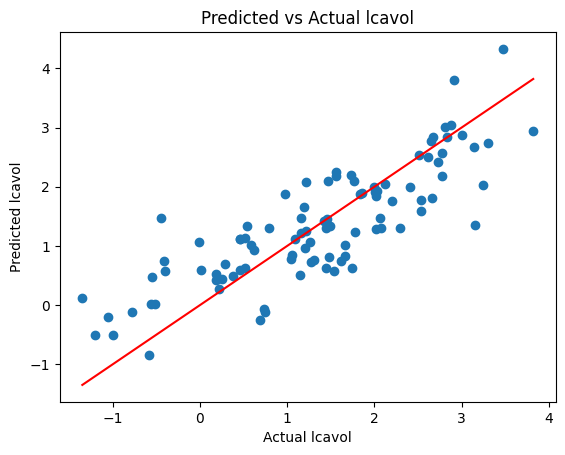

In [43]:
y_pred = results.get_prediction(X).predicted_mean

plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
plt.xlabel('Actual lcavol')
plt.ylabel('Predicted lcavol')
plt.title('Predicted vs Actual lcavol')
plt.show()


**(h)** Plot the histogram of residuals as well as their qq-plot using `statsmodels` function `qqplot`. Can we admit that the residuals are normally distributed? Compute the residual sum of squares (RSS).

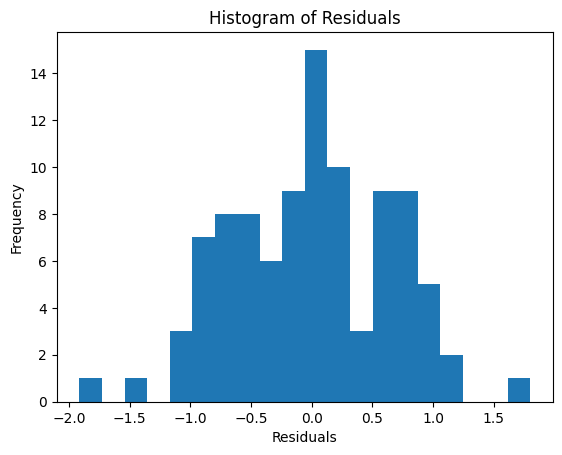

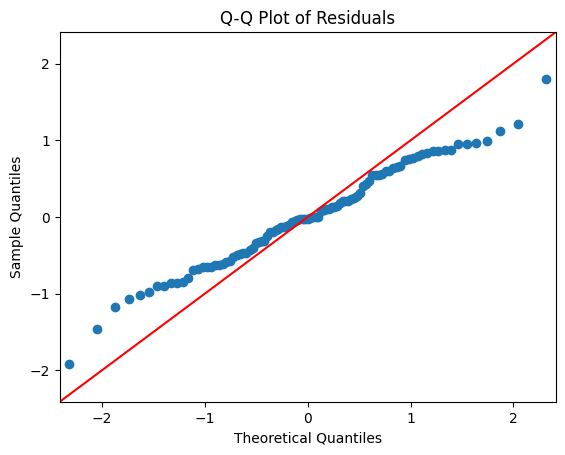

Residual Sum of Squares: 41.81406860804535


In [44]:
residuals = y - results.fittedvalues

# Histogram
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='45') # it compares the distribution of the residuals to that of the Gaussian distribution N(0,1
plt.title('Q-Q Plot of Residuals')
plt.show()

# Residual Sum of Squares
RSS = np.sum(residuals**2)
print("Residual Sum of Squares:", RSS)


**Comments:**
- The histogram provides an estimate of the residuals' density. In our case, it is approximately symmetric and centered around zero, resembling a Gaussian distribution (even more so if normalized).
- The Q-Q plot shows that the quantiles of the residuals are close to the theoretical quantiles of a standard normal distribution, as the points closely follow the first bisector. This suggests that the residuals are approximately normally distributed.


**(i)** What happens if predictors `lpsa` and `lcp` are removed from the multiple linear regression model? Note that you can pass a list of strings to `df.columns.drop` method.

In [45]:
# Drop lpsa and lcp from predictors
X_rem = X.drop(columns=['lpsa', 'lcp'])

model_rem = sm.OLS(y, X_rem)
results_rem = model_rem.fit()

print(results_rem.summary())

                            OLS Regression Results                            
Dep. Variable:                 lcavol   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     8.390
Date:                Sun, 15 Feb 2026   Prob (F-statistic):           2.11e-08
Time:                        20:34:15   Log-Likelihood:                -125.58
No. Observations:                  97   AIC:                             269.2
Df Residuals:                      88   BIC:                             292.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lweight        0.5850      0.259      2.257      0.0

**Comments:**
- The model explains about 43.3\% of the variance in lcavol, which is lower than the full model ($R^2 = 0.686$), showing that **lpsa** and **lcp** were important predictors.
- Predictors that weren't significant before are now significant ($p < 0.05$) in the reduced model: **lweight**, **svi_1**, **gleason_7**.
- Higher standard errors are due to removing strong predictors **lpsa**, **lcp**. In other words removing such important parameters increased the uncertainty of the model.


## ▶️ Exercise 3: Best subset selection (5 points)

A regression model that uses $k$ predictors is said to be of size $k$. For instance, 

$$
\texttt{lcavol} = \beta_1 \texttt{lpsa} + \beta_0 + \varepsilon \quad \text{and} \quad \texttt{lcavol} = \beta_1 \texttt{lweight} + \beta_0 + \varepsilon
$$

are models of size one. The regression model without any predictor $\texttt{lcavol} = \beta_0 + \varepsilon$ is a model of size 0.

The goal of this exercise is to select the best model of size $k$ for each $k \in \{0, \dots, 8\}$.

**(a)** Compute the residual sums of squares (RSS) for all models of size $k = 2$. Which model has the smallest RSS? Note that you can use a generator [`itertools.combination`](https://docs.python.org/3/library/itertools.html#itertools.combinations) to automatize for you all the combinations of $k$ elements among $n$.

**(b)** For each value of $k \in \{0, \dots, 8\}$, select the set of predictors that minimizes the RSS. Plot these values as a function of $k$. Provide the names of the selected predictors for each value of $k$.

**(c)** Do you think that minimizing the residual sum of squares is well suited to select the optimal size for the regression models? Justify your answer using what you've learned in class.

In [74]:
import itertools as itt
import statsmodels.api as sm
import pandas as pd

predictors = list(X.columns)
predictors.remove('intercept')  # Remove intercept as it's not part of predictors

def rss_combination(comb):
    X_reduced = X[['intercept'] + list(comb)]
    model_reduced = sm.OLS(y, X_reduced)
    results_reduced = model_reduced.fit()
    return results_reduced.ssr

def rss_k(k):
    combinations = []
    for comb in itt.combinations(predictors, k):
        combinations.append((comb, rss_combination(comb)))
    return combinations

def rss_ks():
    rss_par_k = {}
    best_combinations = {}
    min_rss = {}
    
    for k in range(9):
        rss_vals = rss_k(k)  # Get all combinations of k predictors
        rss_par_k[k] = rss_vals
        
        best_comb = min(rss_vals, key=lambda x: x[1])  # Get the combination with the minimum RSS
        best_combinations[k] = best_comb[0]  # Store best combination
        min_rss[k] = best_comb[1]  # Store its RSS value
        
    return rss_par_k, best_combinations, min_rss

# a) RSS for all combinations of size 2
print("a) RSS for all combinations of size 2:\n")
rss_k_2 = rss_k(2)
print(pd.DataFrame(rss_k_2, columns=["Predictors", "RSS"]))
print()

a) RSS for all combinations of size 2:

                Predictors         RSS
0           (lweight, age)  120.402501
1          (lweight, lbph)  121.313982
2           (lweight, lcp)   68.607649
3         (lweight, pgg45)  100.895025
4          (lweight, lpsa)   61.187121
5         (lweight, svi_1)   89.345270
6     (lweight, gleason_7)  103.296086
7     (lweight, gleason_8)  122.862048
8     (lweight, gleason_9)  119.128742
9              (age, lbph)  126.205508
10              (age, lcp)   69.930206
11            (age, pgg45)  106.680686
12             (age, lpsa)   60.035697
13            (age, svi_1)   91.106194
14        (age, gleason_7)  107.206570
15        (age, gleason_8)  126.542413
16        (age, gleason_9)  124.290212
17             (lbph, lcp)   72.404193
18           (lbph, pgg45)  108.274320
19            (lbph, lpsa)   59.909789
20           (lbph, svi_1)   93.909833
21       (lbph, gleason_7)  109.913250
22       (lbph, gleason_8)  133.251400
23       (lbph, gleason_

In [75]:
# the best combination for k=2 
best_comb_2 = min(rss_k_2, key=lambda x: x[1])
best_combination_2 = best_comb_2[0]
min_rss_2 = best_comb_2[1]
print(f"Best combination for k=2: {best_combination_2} with RSS: {min_rss_2}\n")


Best combination for k=2: ('lcp', 'lpsa') with RSS: 47.27809728978648



In [76]:
# b) RSS for all combinations of all sizes
print("\nb) RSS for all combinations of all sizes and the best combinations for each k:\n")
rss_par_k, best_combinations, min_rss = rss_ks()

for k, rss_vals in rss_par_k.items():
    print(f"Combinations for k={k}:")
    print(pd.DataFrame(rss_vals, columns=["Predictors", "RSS"]))
    print(f"k={k}: Best predictors: {best_combinations[k]} with RSS: {min_rss[k]}")
    print()


b) RSS for all combinations of all sizes and the best combinations for each k:

Combinations for k=0:
  Predictors         RSS
0         ()  133.359034
k=0: Best predictors: () with RSS: 133.35903388922304

Combinations for k=1:
     Predictors         RSS
0    (lweight,)  122.864712
1        (age,)  126.607740
2       (lbph,)  133.259280
3        (lcp,)   72.541413
4      (pgg45,)  108.280298
5       (lpsa,)   61.420907
6      (svi_1,)   94.637713
7  (gleason_7,)  110.000470
8  (gleason_8,)  133.353635
9  (gleason_9,)  130.167081
k=1: Best predictors: ('lpsa',) with RSS: 61.420907416789916

Combinations for k=2:
                Predictors         RSS
0           (lweight, age)  120.402501
1          (lweight, lbph)  121.313982
2           (lweight, lcp)   68.607649
3         (lweight, pgg45)  100.895025
4          (lweight, lpsa)   61.187121
5         (lweight, svi_1)   89.345270
6     (lweight, gleason_7)  103.296086
7     (lweight, gleason_8)  122.862048
8     (lweight, gleason_9) 

In [77]:
# Summary of the best combinations and their corresponding RSS values
print("\nSummary of the Best combinations for each k with corresponding RSS:")
for k in range(9):
    print(f"k={k}: Best predictors: {best_combinations[k]} with RSS: {min_rss[k]}")



Summary of the Best combinations for each k with corresponding RSS:
k=0: Best predictors: () with RSS: 133.35903388922304
k=1: Best predictors: ('lpsa',) with RSS: 61.420907416789916
k=2: Best predictors: ('lcp', 'lpsa') with RSS: 47.27809728978648
k=3: Best predictors: ('age', 'lcp', 'lpsa') with RSS: 46.237825150928
k=4: Best predictors: ('age', 'lbph', 'lcp', 'lpsa') with RSS: 44.87840603234042
k=5: Best predictors: ('age', 'lbph', 'lcp', 'pgg45', 'lpsa') with RSS: 44.31133248731897
k=6: Best predictors: ('age', 'lbph', 'lcp', 'pgg45', 'lpsa', 'gleason_8') with RSS: 43.77602097098613
k=7: Best predictors: ('age', 'lbph', 'lcp', 'pgg45', 'lpsa', 'gleason_7', 'gleason_9') with RSS: 42.47364094908342
k=8: Best predictors: ('age', 'lbph', 'lcp', 'pgg45', 'lpsa', 'gleason_7', 'gleason_8', 'gleason_9') with RSS: 42.17393288847962


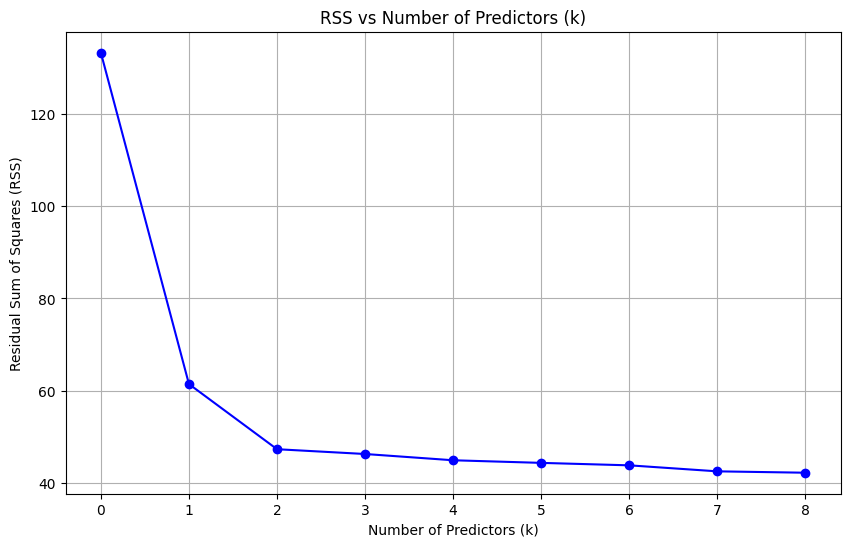

In [78]:
# Plotting the minimum RSS for each k
plt.figure(figsize=(10, 6))
plt.plot(list(min_rss.keys()), list(min_rss.values()), marker='o', linestyle='-', color='b')

plt.title('RSS vs Number of Predictors (k)')
plt.xlabel('Number of Predictors (k)')
plt.ylabel('Residual Sum of Squares (RSS)')
plt.xticks(list(min_rss.keys()))
plt.grid(True)
plt.show()

**Comment:**

For each value of $k$, we identified the combination of $k$ predictors that minimizes the Residual Sum of Squares (RSS). As expected, adding more predictors generally reduces the RSS, indicating a better fit of the model to the data. However, the reduction in RSS diminishes as $k$ increases, reflecting diminishing returns when including additional predictors. 

The selected predictors for smaller $k$ (e.g., $k=1$ or $k=2$) tend to be those most strongly correlated with **lcavol**, such as **lpsa**, **lcp**, and **age**. For larger $k$, less influential predictors are included to further reduce the RSS, but the improvement is relatively small. This pattern highlights the importance of variable selection: including only the most relevant predictors captures most of the explainable variation while avoiding unnecessary complexity. 

The plot of minimum RSS versus $k$ shows a steep decrease for the first few predictors, then gradually flattens, which is consistent with the principle of parsimony in regression modeling.


## ▶️ Exercise 4: Split-validation (5 points)

You have now found the best model for each of the nine possible model sizes. In the following, we wish to compare these nine diﬀerent regression models.

**(a)** Give a brief overview of split-validation: how it works? Why it is not subject to the same issues raised in
the item (c) of the previous Exercise?

**(b)** Use function `train_test_split` from the `sklearn` package to split the dataset into a training and a validation (or test) partition. You can set `test_size=0.3`. For each of the nine models from before (i.e. those that minimized the RSS for each size $k$), compute the mean prediction error calculated over the samples from the test set and compare it to its corresponding mean training error. Plot a curve for each of these error as a function of size $k$. 

**(c)** Based on the previous results, choose the best model for this dataset, giving the parameter estimates for the model trained on the whole dataset (i.e. without splitting), and explain your choice.

**(d)** What is the main limitation of split-validation ? Illustrate this issue on the cancer dataset. What could
you do to address this problem? Code such alternative method and comment the result. Note that `sklearn` can provide you with many choices. See [here](https://scikit-learn.org/stable/model_selection.html) for more information.

**a) Split-Validation Overview**

Split-validation (also called the train-test split) consists of dividing the dataset into two disjoint parts:

- **training set**, used to estimate the model parameters.
- **test set**, used to evaluate predictive performance on unseen data.

Let $(X_{\text{train}}, y_{\text{train}})$ and $(X_{\text{test}}, y_{\text{test}})$ denote these two subsets. 
The least-squares estimator is computed using only the training data:
$$
\hat{\beta}_{\text{train}} = 
(X_{\text{train}}^\top X_{\text{train}})^{-1} 
X_{\text{train}}^\top y_{\text{train}}.
$$

Predictions on the test set are then given by
$$
\hat{y}_{\text{test}} = X_{\text{test}} \hat{\beta}_{\text{train}},
$$
and the prediction error is measured by the RSS):
$$
\text{RSS}_{\text{test}} =
\sum_{i \in \text{test}} 
\left(y_i - \hat{y}_i\right)^2.
$$

**Why split-validation avoids the issue of minimizing RSS**

When minimizing the residual sum of squares (RSS) on the training data,
$$
\text{RSS}_{\text{train}} = \|y_{\text{train}} - X_{\text{train}}\hat{\beta}_{\text{train}}\|^2,
$$
adding predictors always weakly decreases RSS. This occurs because the fitted values are the orthogonal projection of $y_{\text{train}}$ onto $\text{Col}(X_{\text{train}})$, and enlarging the column space can only reduce the distance to $y_{\text{train}}$.

In fact :

The least-squares estimator is defined by
$$
\hat{\beta} = \arg\min_{\beta \in \mathbb{R}^p} \|y - X\beta\|^2.
$$

The fitted values are
$$
\hat{y} = X\hat{\beta}.
$$

Solving the normal equations,
$$
X^\top X \hat{\beta} = X^\top y,
$$
gives
$$
\hat{\beta} = (X^\top X)^{-1} X^\top y.
$$

Therefore,

$$
\hat{y} = X (X^\top X)^{-1} X^\top y = P y,
$$
where
$$
P = X (X^\top X)^{-1} X^\top.
$$

The matrix $P$ satisfies:
$$
P^2 = P
\quad \text{and} \quad
P^\top = P,
$$
so $P$ is an orthogonal projection matrix.

Moreover,
$$
\hat{y}=\arg\min_{v \in \mathrm{Col}(X)} \|y - v\|.
$$

Hence, $\hat{y}$ is the **orthogonal projection** of $y$ onto the column space of $X$, denoted $\mathrm{Col}(X)$, since it is nothing but the producti of X and a vector.

**Adding a new predictor**

Now suppose we add a new predictor $x_{p+1}$ and define
$$
\tilde{X} = [X, x_{p+1}] \in \mathbb{R}^{n \times (p+1)}.
$$

Then,
$$
\mathrm{Col}(X) \subseteq \mathrm{Col}(\tilde{X}),
$$
since every linear combination of the original columns is still available.

The new least-squares estimator is

$$
\hat{\beta}_{\text{new}}=(\tilde{X}^\top \tilde{X})^{-1} \tilde{X}^\top y,
$$

and the new fitted values are
$$
\hat{y}_{\text{new}}=\tilde{X}(\tilde{X}^\top \tilde{X})^{-1}\tilde{X}^\top y=\tilde{P}y,
$$

where

$$
\tilde{P}=\tilde{X}(\tilde{X}^\top \tilde{X})^{-1}\tilde{X}^\top
$$
is the orthogonal projection matrix onto $\mathrm{Col}(\tilde{X})$.

Since $\mathrm{Col}(X) \subseteq \mathrm{Col}(\tilde{X})$, we are minimizing over a larger space:
$$
\|y - \hat{y}_{\text{new}}\|
$$

$$
\min_{v \in \mathrm{Col}(\tilde{X})} \|y - v\|\leq \min_{v \in \mathrm{Col}(X)} \|y - v\| =\|y - \hat{y}\|.
$$

Therefore,
$$
\text{RSS}_{\text{new}} \leq \text{RSS}_{\text{old}}.
$$

Adding a predictor can only decrease (or leave unchanged) the residual sum of squares, because the orthogonal projection is taken onto a larger subspace.



However, this monotonic decrease reflects improved **in-sample fit** only. It does not guarantee better predictive performance. It is what we call an **overfitting** as it relies on the same matrix **X** with additional degrees of freedom.

Split-validation avoids this issue because the model is evaluated on data that were not used to compute the projection. The validation error depends on how well the estimated coefficients generalize to new observations. When unnecessary predictors are added, the model may overfit the training data, which can increase the MSPE on the test set.

Therefore, unlike training RSS, the validation error is not guaranteed to decrease with model complexity and provides a more reliable criterion for model selection.


**b)**

 the mean squared testing Error made for k = 0 is 1.5853556184408277s
 the mean squared testing Error made for k = 1 is 0.7812324440369814s
 the mean squared testing Error made for k = 2 is 0.5754303217408931s
 the mean squared testing Error made for k = 3 is 0.5637364055455804s
 the mean squared testing Error made for k = 4 is 0.5523339510113716s
 the mean squared testing Error made for k = 5 is 0.5620205217536314s
 the mean squared testing Error made for k = 6 is 0.5619451894881221s
 the mean squared testing Error made for k = 7 is 0.5518659078586143s
 the mean squared testing Error made for k = 8 is 0.5516360672443592s


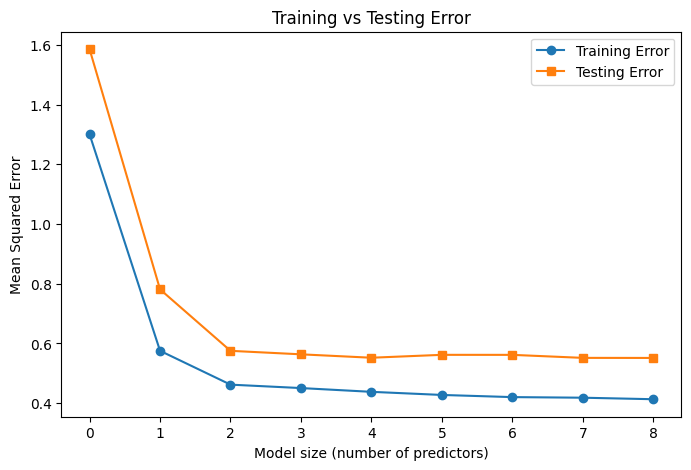

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_errors = []
test_errors = []

for k in range(0, 9):
    predictors_k = best_combinations[k]  # best predictors of size k
    X_train_k = sm.add_constant(X_train[list(predictors_k)]) {add constant for the intercept
    X_test_k = sm.add_constant(X_test[list(predictors_k)])
    
    model = sm.OLS(y_train, X_train_k).fit()
    
    y_train_pred = model.fittedvalues
    y_test_pred = model.predict(X_test_k)
    
    train_errors.append(np.mean((y_train - y_train_pred)**2))
    test_errors.append(np.mean((y_test - y_test_pred)**2))
    print(f' the mean squared testing Error made for k = {k} is {np.mean((y_test - y_test_pred)**2)}s')

# Plot training and validation errors
plt.figure(figsize=(8,5))
plt.plot(range(0,9), train_errors, label='Training Error', marker='o')
plt.plot(range(0,9), val_errors, label='Testing Error', marker='s')
plt.xlabel('Model size (number of predictors)')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Testing Error')
plt.legend()
plt.show()



**c) Choosing the Best Model**

The model with the lowest validation (test) Mean Squared Error is obtained for 
$k = 8$, with

$$
\text{MSE}_{\text{test}}(8) = 0.5516.
$$

However, the improvement in predictive performance becomes negligible after 
$k = 4$. In particular,

$$
\text{MSE}_{\text{test}}(4) = 0.5523, \quad
\text{MSE}_{\text{test}}(7) = 0.5519, \quad
\text{MSE}_{\text{test}}(8) = 0.5516.
$$

The difference between $k = 4$ and $k = 8$ is

$$
0.5523 - 0.5516 \approx 0.0007,
$$

which is extremely small. Therefore, although the absolute minimum validation 
error is achieved at $k = 8$, the gain compared to $k = 4$ is negligible.

So the model with  $k = 4$ predictors. It provides nearly identical predictive performance while remaining simpler, reducing the risk of overfitting and improving interpretability.

One could even argue that the best model is the one with $k = 2$ as The difference between $k = 4$ and $k = 8$ is

$$
0.5754 - 0.5516  \approx 0.0238,
$$
which is small as well, and requieres 6 less parameters.


In [88]:
print("summary for k = 2 :\n")
X_best2 = sm.add_constant(X[list(best_combinations[2])])
best_model_2 = sm.OLS(y, X_best2).fit()
print(best_model_2.summary())
print()
print("summary for k = 4 :\n")
X_best4 = sm.add_constant(X[list(best_combinations[4])])
best_model_4 = sm.OLS(y, X_best4).fit()
print(best_model_4.summary())

summary for k = 2 :

                            OLS Regression Results                            
Dep. Variable:                 lcavol   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     85.57
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           6.81e-22
Time:                        22:03:15   Log-Likelihood:                -102.78
No. Observations:                  97   AIC:                             211.6
Df Residuals:                      94   BIC:                             219.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0913      0.20

**Comparison Based on $R^2$ and Adjusted $R^2$**

**Model $k=2$**
- $R^2 = 0.645$: the model explains 64.5\% of the total variance of $lcavol$.
- Adjusted $R^2 = 0.638$: slightly lower than $R^2$, accounting for the number of predictors.
- Number of predictors: 2 (lcp and lpsa).


**Model $k=4$**

- $R^2 = 0.663$: the model explains 66.3\% of the total variance, a gain of 1.8\% compared to the 2-predictor model.
- Adjusted $R^2 = 0.649$: slightly higher than for $k=2$, reflecting the increased explained variance while penalizing model complexity.
- Number of predictors: 4 (lcp, lpsa, age, lbph).


**3. Conclusion**
- Increasing the number of predictors from 2 to 4 provides only a marginal gain in $R^2$ and Adjusted $R^2$.
- The 2-predictor model remains very effective and simpler to interpret.
- Considering the trade-off between performance and simplicity, the $k=2$ model is often preferred.

**d) Limitation of Split-Validation**

The main limitation of split-validation is that the results depend on a single random split of the data. In small datasets, this can lead to high variance in error estimates and an unreliable model selection. For instance, different splits of the cancer dataset may suggest different best models.

**Alternative: Cross-Validation**

K-fold cross-validation mitigates this problem by partitioning the data into $K$ folds, training on $K-1$ folds, and validating on the remaining fold. This process is repeated $K$ times, and the validation errors are averaged.

Python code using 5-fold cross-validation:

2- Fold:
mse for k = 0 : 2.614790116015544
mse for k = 1 : 0.6394284871592
mse for k = 2 : 0.5811309906481976
mse for k = 3 : 0.5514568415360317
mse for k = 4 : 0.5936313797810736
mse for k = 5 : 0.5878876037811289
mse for k = 6 : 0.6585437146550133
mse for k = 7 : 0.5441505553071216
mse for k = 8 : 0.6096811012331029
5- Fold:
mse for k = 0 : 1.741600485891487
mse for k = 1 : 0.630476060976595
mse for k = 2 : 0.5171740772226285
mse for k = 3 : 0.5141657201467935
mse for k = 4 : 0.5211565772953317
mse for k = 5 : 0.5222058736986064
mse for k = 6 : 0.5327995475832501
mse for k = 7 : 0.4947461731217504
mse for k = 8 : 0.5023935973704989
10- Fold:
mse for k = 0 : 1.557217899951484
mse for k = 1 : 0.6355039094346044
mse for k = 2 : 0.5074887319260216
mse for k = 3 : 0.5014127023120184
mse for k = 4 : 0.5094671864360462
mse for k = 5 : 0.5122563474133918
mse for k = 6 : 0.5155466365570973
mse for k = 7 : 0.4921508548560176
mse for k = 8 : 0.49515650192001
15- Fold:
mse for k = 0 : 1.49080239

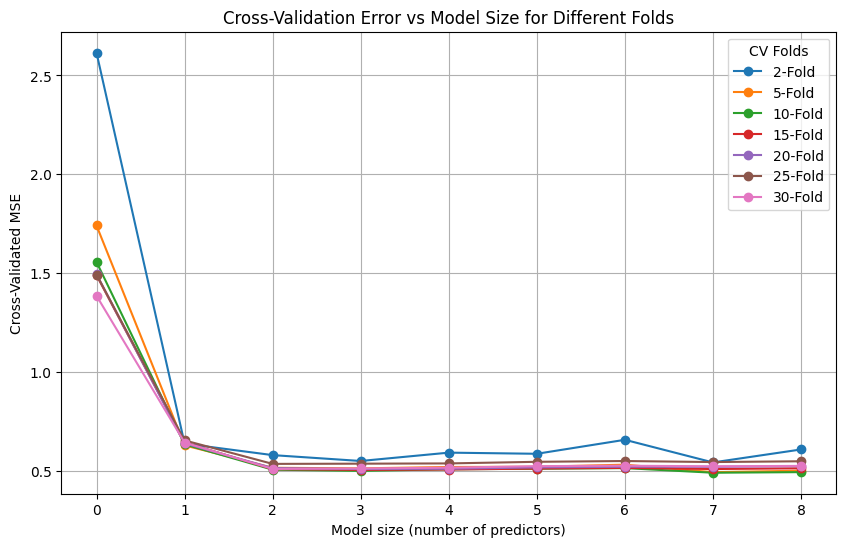

In [135]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

mses = {}

for crossv in ( 2, 5, 10, 15, 20, 25, 30):
    cv_errors = []  # reset the list every time
    print(f'{crossv}- Fold:')
    for k in range(0, 9):
        predictors_k = list(best_combinations[k])
        X_k = sm.add_constant(X[predictors_k]).values
        y_k = y.values
        model = LinearRegression()
        
        # The MSE is negative in sklearn, so we'll take -1 * score
        mse = -cross_val_score(model, X_k, y_k, cv=crossv, scoring='neg_mean_squared_error').mean()
        cv_errors.append(mse)
        print(f'mse for k = {k} : {mse}')
    mses[crossv] = cv_errors
    
plt.figure(figsize=(10,6))

for crossv, cv_errors in mses.items():
    plt.plot(range(0, 9), cv_errors, marker='o', label=f'{crossv}-Fold')

plt.xlabel('Model size (number of predictors)')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation Error vs Model Size for Different Folds')
plt.xticks(range(0, 9))
plt.grid(True)
plt.legend(title='CV Folds')
plt.show()



In [131]:

all_mse = np.array([mses[2], mses[5], mses[10], mses[15], mses[20], mses[25], mses[30]])
mean_mse = all_mse.mean(axis=0)

for k, mse in enumerate(mean_mse):
    print(f"Average MSE for k={k}: {mse:.4f}")


Average MSE for k=0: 1.6829
Average MSE for k=1: 0.6417
Average MSE for k=2: 0.5257
Average MSE for k=3: 0.5194
Average MSE for k=4: 0.5288
Average MSE for k=5: 0.5325
Average MSE for k=6: 0.5463
Average MSE for k=7: 0.5192
Average MSE for k=8: 0.5319


# Cross-Validation Analysis

Based on repeated k-fold cross-validation with `k = 2, 5, 10, 15, 20, 25, 30`, we computed the **average mean squared error (MSE)** for each model size. The results are:

| Model size (k) | Average MSE |
|----------------|------------|
| 0              | 1.6829     |
| 1              | 0.6417     |
| 2              | 0.5257     |
| 3              | 0.5194     |
| 4              | 0.5288     |
| 5              | 0.5325     |
| 6              | 0.5463     |
| 7              | 0.5192     |
| 8              | 0.5319     |

We observe that the **lowest average MSE occurs around k = 3 and k = 7**, with values very close to each other. This suggests that models with **2–4 predictors** provide a good balance between model complexity and predictive accuracy. Increasing the number of predictors beyond this range does not substantially reduce the MSE and may lead to overfitting.


## ▶️ Exercise 5: Conclusion (2 points)

What is your conclusion about the choice of the best model to predict `lcavol` ? Comment your results.

**Conclusion**

Based on the analysis of RSS, adjusted R², and cross-validated MSE for different model sizes:

Small models ($k=2$): Already provide a strong predictive power with $R^2 \approx 0.645$ and a cross-validated MSE around $0.526$ on average. The predictors lcp and lpsa capture most of the variability in lcavol.

Medium models ($k=3$ or $k=4$): Slightly improve $R^2$ to $0.663$ and reduce MSE only marginally compared to $k=2$ (for $k=3$, for $k=4$ however the MSE is relatively higher on average across all cross-validation tests). Adding age and lbph increases complexity but only gives a tiny gain in prediction performance.

Larger models ($k>4$): Do not consistently improve cross-validated MSE, and sometimes even increase it, indicating potential overfitting.

Choice of best model:

Considering parsimony and predictive accuracy, the model with $k=2$ predictors (lcp and lpsa) (and arguably $k = 3$) is the best choice.
